In [1]:
import lexical_decision as ld
import reestimation as reest
import corpus
import util
import importlib
import numpy as np
import pandas as pd
import scipy.sparse
import pickle
#importlib.reload(reest)

# Loading data

In [2]:
lda = reest.LDA()
n_topics = [5, 20, 80]
lda.load_models('./../subtitles/gensim-models-all/', n_topics)

In [4]:
corpus_path = './data/document_word_matrix.npz'
docs = scipy.sparse.load_npz(corpus_path)
print(docs.shape)

(97388, 25626)


In [8]:
vocab_path = './data/vocab.pkl'
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)
    vocab = vocab['words']
    wc = corpus.WordCount(docs.T, vocab)

In [9]:
#importlib.reload(ld)
blp = ld.BLP('./../BLP', words=set(vocab))

# Experiment 1

### Group 1 vs. Group 2

In [10]:
groups = [1, 2]
group_rts = [blp.get_rt_group(gr=gr_no, mean=True).values for gr_no in groups]
results = []

for n_components in n_topics:
    beta = lda.get_beta(n_components)
    for train_gr in groups:
        coef = reest.fit(beta, group_rts[train_gr-1])
        probs = reest.reestimate(beta, coef)
        for test_gr in groups:
            rts = group_rts[test_gr-1]
            rr = util.rsq(probs, rts)
            rr_bl = util.rsq(wc.freq_million_log, rts)
            results.append((n_components, train_gr, test_gr, rr, rr_bl))

In [11]:
results_df = pd.DataFrame(results, columns=[
    'n_topics', 'train_group', 'test_group', 'rr_reestimated', 'rr_baseline'
]).groupby(['n_topics', 'train_group', 'test_group']).agg('mean')
bl_diffs = results_df['rr_reestimated'] - results_df['rr_baseline']
results_df['diff'] = bl_diffs
results_df

rr_reestimated  rr_baseline      diff
n_topics train_group test_group                                       
5        1           1                 0.266721     0.252128  0.014593
                     2                 0.281876     0.268829  0.013047
         2           1                 0.266681     0.252128  0.014553
                     2                 0.281918     0.268829  0.013088
20       1           1                 0.325430     0.252128  0.073302
                     2                 0.340638     0.268829  0.071809
         2           1                 0.324101     0.252128  0.071973
                     2                 0.342024     0.268829  0.073195
80       1           1                 0.338447     0.252128  0.086319
                     2                 0.356409     0.268829  0.087579
         2           1                 0.330917     0.252128  0.078789
                     2                 0.364723     0.268829  0.095894

### Individuals
group based vs. individual based

In [113]:
groups = [1, 2]
group_rts = [blp.get_rt_group(gr=gr_no, mean=True).values for gr_no in groups]
results = []

for n_components in n_topics:
    beta = lda.get_beta(n_components)
    for gr_no in groups:
        coef_gr = reest.fit(beta, group_rts[gr_no-1])
        probs_gr = reest.reestimate(beta, coef_gr)        
        for pid in blp.get_participants(gr_no):
            rts = blp.get_rt_participant(pid)
            coef_pt = reest.fit(beta, rts)
            probs_pt = reest.reestimate(beta, coef_pt)
            rr_pt = util.rsq(probs_pt, rts)
            rr_gr = util.rsq(probs_gr, rts)
            rr_bl = util.rsq(wc.freq_million_log, rts)
            results.append((n_components, gr_no, pid, rr_pt, rr_gr, rr_bl))

In [118]:
results_df = pd.DataFrame(results, columns=[
    'n_components', 'group_number', 'participant', 'rr_ind', 'rr_group', 'rr_baseline'
])
results_df['diff_ind'] = results_df['rr_ind'] - results_df['rr_baseline']
results_df['diff_gr'] = results_df['rr_group'] - results_df['rr_baseline']
results_agg = results_df.groupby(['group_number', 'n_components']).agg(['mean', 'std'])
results_agg

participant               rr_ind            \
                                 mean        std      mean       std   
group_number n_components                                              
1            5              50.150000  31.604568  0.065938  0.026792   
             20             50.150000  31.604568  0.079814  0.030738   
             80             50.150000  31.604568  0.087774  0.031121   
2            5              48.578947  31.715485  0.073302  0.028272   
             20             48.578947  31.715485  0.088806  0.032629   
             80             48.578947  31.715485  0.098558  0.033316   

                           rr_group           rr_baseline            diff_ind  \
                               mean       std        mean       std      mean   
group_number n_components                                                       
1            5             0.065474  0.026881    0.062157  0.026467  0.003781   
             20            0.077654  0.030789    0.062157  0.026467  0.017657   
             80            0.080194  0.031732    0.062157  0.026467  0.025617   
2            5             0.072755  0.028227    0.069407  0.027565  0.003894   
             20            0.086485  0.032314    0.069407  0.027565  0.019399   
             80            0.090762  0.033507    0.069407  0.027565  0.029150   

                                      diff_gr            
                                std      mean       std  
group_number n_components                                
1            5             0.001561  0.003317  0.001496  
             20            0.005779  0.015497  0.005953  
             80            0.006177  0.018037  0.006703  
2            5             0.002150  0.003348  0.002022  
             20            0.006512  0.017077  0.006235  
             80            0.007181  0.021355  0.007358

In [119]:
results_df = pd.DataFrame(results, columns=[
    'n_components', 'group_number', 'participant', 'rr_ind', 'rr_group', 'rr_baseline'
])
results_df['diff_ind'] = results_df['rr_ind'] - results_df['rr_baseline']
results_df['diff_gr'] = results_df['rr_group'] - results_df['rr_baseline']
results_agg = results_df.groupby(['n_components']).agg(['mean', 'std'])
results_agg

group_number           participant               rr_ind  \
                     mean       std        mean        std      mean   
n_components                                                           
5                1.487179  0.503071   49.384615  31.462297  0.069525   
20               1.487179  0.503071   49.384615  31.462297  0.084195   
80               1.487179  0.503071   49.384615  31.462297  0.093027   

                        rr_group           rr_baseline            diff_ind  \
                   std      mean       std        mean       std      mean   
n_components                                                                 
5             0.027593  0.069021  0.027609    0.065689  0.027078  0.003836   
20            0.031790  0.081956  0.031648    0.065689  0.027078  0.018506   
80            0.032455  0.085343  0.032829    0.065689  0.027078  0.027338   

                         diff_gr            
                   std      mean       std  
n_components                                
5             0.001860  0.003332  0.001760  
20            0.006169  0.016267  0.006104  
80            0.006875  0.019654  0.007180

# Experiment 2

### Aggregate (group 1)

In [27]:
subset = blp.words_idx_2
mc = 100
results = []
splits = [.125, .25, .5]

for n_components in n_topics:
    beta = lda.get_beta(n_components)  
    rts = blp.get_rt_group(2, mean=True)[subset]
    for split in splits:
        for seed in np.arange(mc):
            train, test = util.random_split(seed, rts, maps=True, train=split)
            coef = reest.fit(beta[subset][train], rts[train])
            probs = reest.reestimate(beta[subset][test], coef)
            rr = util.rsq(probs, rts[test])
            rr_bl = util.rsq(wc.freq_million_log[subset][test], rts[test])
            results.append((n_components, split, seed, rr, rr_bl))

In [28]:
results_df = pd.DataFrame(results, columns=[
    'n_components', 'split', 'seed', 'rr', 'rr_baseline'
]).groupby(['n_components', 'split'])[['rr', 'rr_baseline']].agg('mean')
results_df['diff'] = results_df['rr']-results_df['rr_baseline']
results_df

rr  rr_baseline      diff
n_components split                                 
5            0.125  0.280115     0.269035  0.011080
             0.250  0.280640     0.268498  0.012142
             0.500  0.281381     0.268808  0.012573
20           0.125  0.333039     0.269035  0.064004
             0.250  0.336936     0.268498  0.068438
             0.500  0.339169     0.268808  0.070361
80           0.125  0.330038     0.269035  0.061003
             0.250  0.345109     0.268498  0.076610
             0.500  0.353347     0.268808  0.084539

### Aggregate (group 2)

In [29]:
subset = blp.words_idx_1
mc = 100
results = []
splits = [.125, .25, .5]

for n_components in n_topics:
    beta = lda.get_beta(n_components)  
    rts = blp.get_rt_group(1, mean=True)[subset]
    for split in splits:
        for seed in np.arange(mc):
            train, test = util.random_split(seed, rts, maps=True, train=split)
            coef = reest.fit(beta[subset][train], rts[train])
            probs = reest.reestimate(beta[subset][test], coef)
            rr = util.rsq(probs, rts[test])
            rr_bl = util.rsq(wc.freq_million_log[subset][test], rts[test])
            results.append((n_components, split, seed, rr, rr_bl))

In [30]:
results_df = pd.DataFrame(results, columns=[
    'n_components', 'split', 'seed', 'rr', 'rr_baseline'
]).groupby(['n_components', 'split'])[['rr', 'rr_baseline']].agg('mean')
results_df['diff'] = results_df['rr']-results_df['rr_baseline']
results_df

rr  rr_baseline      diff
n_components split                                 
5            0.125  0.264422     0.251919  0.012503
             0.250  0.264910     0.251684  0.013225
             0.500  0.265603     0.251818  0.013786
20           0.125  0.315889     0.251919  0.063970
             0.250  0.319390     0.251684  0.067706
             0.500  0.321581     0.251818  0.069763
80           0.125  0.301728     0.251919  0.049809
             0.250  0.316809     0.251684  0.065124
             0.500  0.325045     0.251818  0.073228

### Individuals

In [121]:
subset = blp.words_idx_2
mc = 10
results = []
splits = [.125, .25, .5]

for n_components in n_topics:
    beta = lda.get_beta(n_components)
    for pid in blp.get_participants(2):
        rts = blp.get_rt_participant(pid)[subset]
        for split in splits:
            for seed in np.arange(mc):
                train, test = util.random_split(seed, rts, maps=True, train=split)
                coef = reest.fit(beta[subset][train], rts[train])
                probs = reest.reestimate(beta[subset][test], coef)
                rr = util.rsq(probs, rts[test])
                rr_bl = util.rsq(wc.freq_million_log[subset][test], rts[test])
                results.append((n_components, pid, split, seed, rr, rr_bl))

In [122]:
results_df = pd.DataFrame(results, columns=[
    'n_components', 'participant', 'split', 'seed', 'rr', 'rr_baseline'
])
results_df['diff'] = results_df['rr'] - results_df['rr_baseline']

In [123]:
results_agg = results_df.groupby(['n_components', 'split']).agg(['mean', 'std'])

In [125]:
results_agg

participant            seed                  rr            \
                          mean        std mean       std      mean       std   
n_components split                                                             
5            0.125   48.578947  31.336653  4.5  2.876068  0.069897  0.028012   
             0.250   48.578947  31.336653  4.5  2.876068  0.071505  0.028246   
             0.500   48.578947  31.336653  4.5  2.876068  0.071816  0.028471   
20           0.125   48.578947  31.336653  4.5  2.876068  0.074556  0.031608   
             0.250   48.578947  31.336653  4.5  2.876068  0.080164  0.032559   
             0.500   48.578947  31.336653  4.5  2.876068  0.083042  0.032820   
80           0.125   48.578947  31.336653  4.5  2.876068  0.054585  0.028220   
             0.250   48.578947  31.336653  4.5  2.876068  0.068419  0.031828   
             0.500   48.578947  31.336653  4.5  2.876068  0.077978  0.033121   

                   rr_baseline                diff            
                          mean       std      mean       std  
n_components split                                            
5            0.125    0.069353  0.027349  0.000544  0.003266  
             0.250    0.069427  0.027377  0.002078  0.002734  
             0.500    0.069141  0.027625  0.002676  0.002944  
20           0.125    0.069353  0.027349  0.005203  0.006999  
             0.250    0.069427  0.027377  0.010737  0.007214  
             0.500    0.069141  0.027625  0.013902  0.007502  
80           0.125    0.069353  0.027349 -0.014768  0.007747  
             0.250    0.069427  0.027377 -0.001008  0.007706  
             0.500    0.069141  0.027625  0.008838  0.008352

In [43]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'split %')

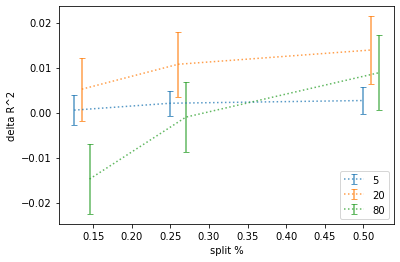

In [73]:
for i, n in enumerate(n_topics):
    subset = results_agg['diff'].loc[n]
    plt.errorbar(subset.index+i*.01, subset['mean'], yerr=subset['std'], label=n, alpha=.75, fmt=':', capsize=3, capthick=1)
plt.legend()
plt.ylabel('delta R^2')
plt.xlabel('split %')

Text(0.5, 0, 'split %')

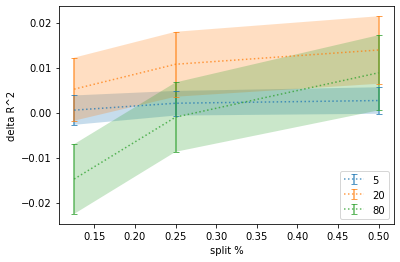

In [53]:
for n in n_topics:
    subset = results_agg['diff'].loc[n]
    plt.errorbar(subset.index, subset['mean'], yerr=subset['std'], label=n, alpha=.75, fmt=':', capsize=3, capthick=1)
    y1 = subset['mean']-subset['std']
    y2 = subset['mean']+subset['std']
    plt.fill_between(x=subset.index, y1=y1, y2=y2, alpha=.25)
plt.legend()
plt.ylabel('delta R^2')
plt.xlabel('split %')

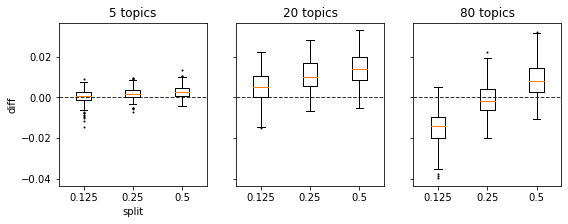

In [112]:
fig, ax = plt.subplots(1, len(n_topics), sharey=True, figsize=(9, 3))
for n, axn in zip(n_topics, ax):
    bp = axn.boxplot([results_df[(results_df['n_components']==n)&(results_df['split']==s)]['diff'] for s in splits], labels=splits)
    #axn.errorbar(*zip(*[results_agg.loc[n, s].index, results_agg.loc[n, s]['mean'] for s in splits]))
    axn.set_title("{} topics".format(n))
    if n == n_topics[0]:
        axn.set_xlabel("split")
        axn.set_ylabel("diff")
    plt.setp(bp['whiskers'], color='k', linestyle='-')
    plt.setp(bp['fliers'], markersize=1.0)
    axn.axhline(0.0, ls='--', color='black', alpha=.8, lw=1)
    axn.axhline()
    
#plt.legend()

In [32]:
results_df = pd.DataFrame(results, columns=[
    'n_components', 'participant', 'split', 'seed', 'rr', 'rr_baseline'
]).groupby(['n_components', 'split'])[['rr', 'rr_baseline']].agg('mean')
results_df['diff'] = results_df['rr']-results_df['rr_baseline']
results_df

rr  rr_baseline      diff
n_components split                                 
5            0.125  0.069897     0.069353  0.000544
             0.250  0.071505     0.069427  0.002078
             0.500  0.071816     0.069141  0.002676
20           0.125  0.074556     0.069353  0.005203
             0.250  0.080164     0.069427  0.010737
             0.500  0.083042     0.069141  0.013902
80           0.125  0.054585     0.069353 -0.014768
             0.250  0.068419     0.069427 -0.001008
             0.500  0.077978     0.069141  0.008838

# Figures

In [138]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Group 1')

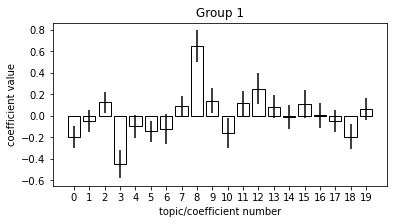

In [143]:
tnum=20
beta=lda.get_beta(tnum)
#plt.hist(topics.mean(axis=1), bins=50)

coefs = []
for pid in blp.get_participants(1):
    rts=blp.get_rt_participant(pid)
    coef = reest.fit(beta, rts)
    coefs.append(coef)
means = np.asarray(coefs).mean(axis=0)
stds = np.asarray(coefs).std(axis=0)

plt.figure(figsize=(6,3))
plt.bar(np.arange(tnum), coef, yerr=stds, edgecolor='black', color='white')
plt.xticks(range(tnum))
plt.xlabel('topic/coefficient number')
plt.ylabel('coefficient value')
plt.title('Group 1')

Text(0.5, 1.0, 'Group 2')

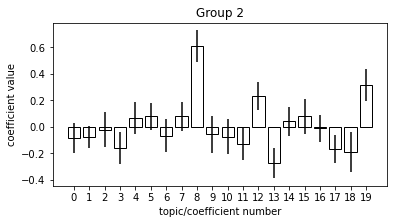

In [144]:
tnum=20
beta=lda.get_beta(tnum)
#plt.hist(topics.mean(axis=1), bins=50)

coefs = []
for pid in blp.get_participants(2):
    rts=blp.get_rt_participant(pid)
    coef = reest.fit(beta, rts)
    coefs.append(coef)
means = np.asarray(coefs).mean(axis=0)
stds = np.asarray(coefs).std(axis=0)

plt.figure(figsize=(6,3))
plt.bar(np.arange(tnum), coef, yerr=stds, edgecolor='black', color='white')
plt.xticks(range(tnum))
plt.xlabel('topic/coefficient number')
plt.ylabel('coefficient value')
plt.title('Group 2')

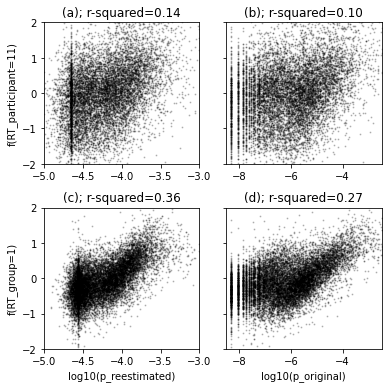

In [173]:
n_components = 80
pid = 11
gr = 2
words_idx = blp.words_idx_2
beta = lda.get_beta(n_components)[words_idx]

y_ind = blp.get_rt_participant(pid)[words_idx]
y_gr = blp.get_rt_group(gr_no, mean=True)[words_idx]

coef_ind = reest.fit(beta, y_ind)
logp_ind = reest.reestimate(beta, coef_ind)
logp_bl_ind = 10**wc.freq_million_log[words_idx]
logp_bl_ind = np.log10(logp_bl_ind / logp_bl_ind.sum())
rr_ind = util.rsq(logp_ind, y_ind)
rr_bl_ind = util.rsq(logp_bl_ind, y_ind)
fin_ind = np.isfinite(y_ind)

coef_gr = reest.fit(beta, y_gr)
logp_gr = reest.reestimate(beta, coef_gr)
logp_bl_gr = logp_bl_ind
rr_gr = util.rsq(logp_gr, y_gr)
rr_bl_gr = util.rsq(logp_bl_gr, y_gr)
fin_gr = np.isfinite(y_gr)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True, sharex=False)
ax1.scatter(logp_ind[fin_ind], y_ind[fin_ind], color='black', s=1, alpha=.2)
ax2.scatter(logp_bl_ind[fin_ind], y_ind[fin_ind], color='black', s=1, alpha=.2)
ax3.scatter(logp_gr[fin_gr], y_gr[fin_gr], color='black', s=1, alpha=.2)
ax4.scatter(logp_bl_gr[fin_gr], y_gr[fin_gr], color='black', s=1, alpha=.2)
ax1.set_ylim((-2,2))
ax3.set_ylim((-2,2))
ax1.set_xlim((-5,-3))
ax2.set_xlim((-8.5,-2.5))
ax3.set_xlim((-5,-3))
ax4.set_xlim((-8.5,-2.5))
ax3.set_xlabel('log10(p_reestimated)')
ax4.set_xlabel('log10(p_original)')
ax1.set_ylabel('f(RT_participant={})'.format(pid))
ax3.set_ylabel('f(RT_group=1)')
ax1.set_title('(a); r-squared={:.2f}'.format(rr_ind))
ax2.set_title('(b); r-squared={:.2f}'.format(rr_bl_ind))
ax3.set_title('(c); r-squared={:.2f}'.format(rr_gr))
ax4.set_title('(d); r-squared={:.2f}'.format(rr_bl_gr))
fig.set_size_inches(5.5,5.5)
fig.tight_layout()

In [171]:
logp_ind[words_idx & fin_ind]

array([-4.9468894, -4.2196856, -4.9045663, ..., -4.5352163, -4.298762 ,
       -4.761025 ], dtype=float32)